In [1]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

#%load_ext autoreload   
#%autoreload 2

#Autoreloading of modules so you don't have to restart kernel after editing .py files

In [2]:
# import tensorflow as tf
# import tensorflow.contrib.eager as tfe
# tf.enable_eager_execution()
import random
import matplotlib.pyplot as plt
import numpy as np
from miniscope_utils_tf import *
from miniscope_model import Model as msu_model
#import utils as krist
import scipy.misc as sc
import scipy.ndimage as ndim
import scipy.misc as misc
from scipy import signal

from skimage.transform import resize as imresize
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
from IPython import display

import os
from os import listdir
from os.path import isfile, join
import matplotlib.animation as animation

import time
from itertools import permutations
from itertools import combinations
#import copy
#from bridson import poisson_disc_samples


In [3]:
#device = '/gpu:0'
#print(tf.test.is_gpu_available())
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
def distances(model, x,y):
    dist = []
    dist_bool = []
    things = np.arange(model.Nlenslets)
    test_perm = list(permutations(things, 2))

    for i in range(0, len(test_perm)):
        dist_i = tf.sqrt(tf.square(x[test_perm[i][0]]-x[test_perm[i][1]])+tf.square(y[test_perm[i][0]]-y[test_perm[i][1]]))
        dist.append(dist_i)
        dist_bool.append(dist_i>0*model.mean_lenslet_CA)  ##fix later
        
    return dist, dist_bool, test_perm

        

In [5]:
#dc_mask = np.ones_like(model.target_F.numpy())  #Mask for DC. Set to zero anywhere we want to ignore loss computation of power spectrum
#dc_mask[:3,:3] = 0
#dc_mask[-2:,:1] = 0
#dc_mask[:1,-2:] = 0
#dc_mask[-2:,-2:]= 0
#plt.figure()
#plt.plot(dc_mask)

## Initialize Model

In [6]:
#model = msu_model()  # zsampling options: 'fixed' or 'uniform_random'
#plt.figure(figsize=(20,20))
#plt.plot(model.xg[model.samples[1]//2:model.samples[1]//2 + 50]*1000,model.target_airy.numpy()[model.samples[0]//2,model.samples[1]//2:model.samples[1]//2 + 50])
#plt.imshow(model.target_F.numpy())

In [7]:
#model2 = msu_model(aberrations = True)  # zsampling options: 'fixed' or 'uniform_random'

In [8]:
#Rmat = model2(0)

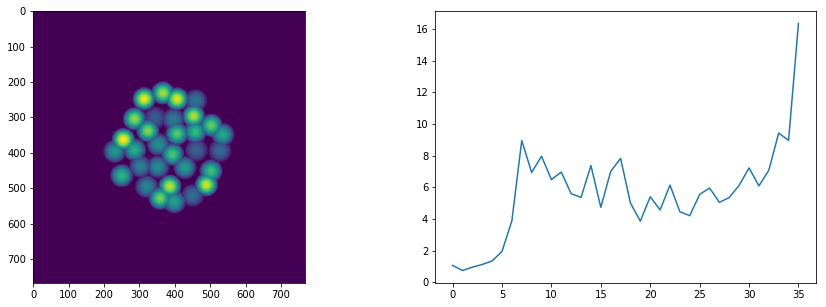

In [9]:
model = msu_model(aberrations = True)  # zsampling options: 'fixed' or 'uniform_random'
Rmat=model(0)

# Save initial values for later comparison 
R_init = Rmat
Tinit,_,_=make_lenslet_tf_zern(model)

xinit = tf.Variable(tf.zeros(model.Nlenslets));       tf.assign(xinit, model.xpos)
yinit = tf.Variable(tf.zeros(model.Nlenslets));       tf.assign(yinit, model.ypos)
rinit = tf.Variable(tf.zeros(model.Nlenslets));       tf.assign(rinit, model.rlist)
#offsetinit = tf.Variable(tf.zeros(model.Nlenslets));  tf.assign(offsetinit, model.lenslet_offset)
zerninit = tf.Variable(tf.zeros((model.Nlenslets, model.numzern))); tf.assign(zerninit, model.zernlist)


model_init=msu_model(aberrations = True)
tf.assign(model_init.xpos, xinit)
tf.assign(model_init.ypos, yinit)
tf.assign(model_init.rlist, rinit)
#tf.assign(model_init.lenslet_offset, offsetinit)
tf.assign(model_init.zernlist, zerninit)
Rmat_init = model_init(0)


fig=plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(Tinit.numpy())
plt.subplot(1,2,2)
plt.plot(R_init.numpy())

Text(0.5, 1.0, 'difference')

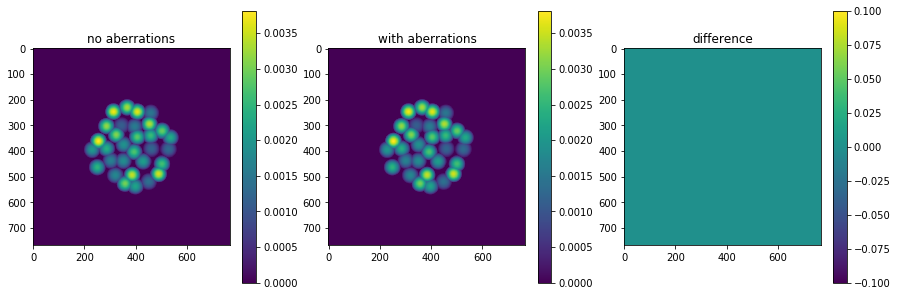

In [10]:
T1 ,_,T2 = make_lenslet_tf_zern(model)
plt.figure(figsize = (15,5))
plt.subplot(1,3,1), plt.imshow(T2); plt.colorbar(); plt.title('no aberrations')
plt.subplot(1,3,2), plt.imshow(T1); plt.colorbar(); plt.title('with aberrations')
plt.subplot(1,3,3), plt.imshow(np.abs(T1-T2)); plt.colorbar(); plt.title('difference')

In [11]:
model_noaber = msu_model(aberrations = False)
tf.assign(model_noaber.xpos, xinit)
tf.assign(model_noaber.ypos, yinit)
tf.assign(model_noaber.rlist, rinit)


<tf.Variable 'UnreadVariable' shape=(31,) dtype=float32, numpy=
array([ 4.0159364,  8.542373 ,  8.064    ,  9.692307 ,  6.9041095,
        4.5201793,  3.7058823,  6.0359282, 11.2      ,  9.081081 ,
        6.5882354,  3.36     ,  4.8229666,  3.5244756,  4.382609 ,
       10.391752 ,  4.990099 ,  7.6363635,  3.8037736,  4.6666665,
        7.2517986,  3.9069767,  6.3      ,  4.253165 ,  3.440273 ,
        5.569061 ,  5.793103 ,  5.169231 ,  4.1311474,  5.361702 ,
        3.612903 ], dtype=float32)>

In [ ]:
# dc_mask = np.ones_like(model.target_F.numpy())  #Mask for DC. Set to zero anywhere we want to ignore loss computation of power spectrum
# dc_mask[:2,:2] = 0
# dc_mask[-1,0] = 0
# dc_mask[0,-1] = 0
# dc_mask[-1,-1] = 0

# plt.figure()
# plt.imshow(dc_mask)
# plt.colorbar()

In [ ]:
#model.load_weights("C:\\Users\\herbtipa\\lenslets_one_per_depth")
#print(model.dc_mask[-1,:10])

In [12]:
plotting_xcorr = False
if plotting_xcorr == True:
    T,aper,_=make_lenslet_tf_zern(model)
    test2 = model.gen_psf_stack(T, aper, .5)
    test = model.gen_stack_spectrum(test2)
    test3=model.gen_correlation_stack(test)
    #ax[0].imshow(T)
    #plt.plot((model.dc_mask * tf.abs(test[1]))[-1,:200].numpy())
    #plt.plot((model.dc_mask * model.target_F)[-1,:200].numpy())
    for z in range(10):
        fig = plt.figure(figsize=(15,5))
        plt.cla()
        plt.plot(np.abs(test3[z][model.samples[0],:]))

        display.display(fig)
        display.clear_output(wait=True)
        plt.pause(.5)

    #     #ax[1].imshow(tf_fftshift(tf.abs((test[z] * tf.conj(test[z])))), vmin = 0, vmax = 50)
    #     #ax[2].imshow(tf_fftshift(tf.abs((test[z] * tf.conj(test[z]))) - model.target_F), vmin = -50, vmax = 50)
    #     plt.cla()
    #     #ax[1].imshow((tf.real((test[z] * tf.conj(test[z])))), vmax = 50)
    #     #plt.imshow(tf_fftshift(np.abs(test[z])))
    #     plt.plot(tf_fftshift(tf.abs(test[z]))[768,:])



In [13]:
# Function to return  maximum cross correlation
def calc_max_xcorr(model):
    
    T,aper, _=make_lenslet_tf_zern(model)
    #model = Model()
    psf_stack = model.gen_psf_stack(T, aper, 0.5)
    stack_spectrum = model.gen_stack_spectrum(psf_stack)
    ccor_mx = []
    for zref in range(model.Nz):
        for z in range(model.Nz):
            xcorr12 = tf.real(tf_fftshift(tf.ifft2d(stack_spectrum[zref]* tf.conj(stack_spectrum[z]))))
            if z != zref:
                ccor_mx.append(tf.reduce_max(xcorr12)) 
                    
    return ccor_mx

def re_init_model(model_in):
    model_in.xpos.assign(xinit)
    model_in.ypos.assign(yinit)

    model_in.lenslet_offset.assign(offsetinit)
    model_in.rlist.assign(rinit)

#have tf do everything for us
def loss (model, inputs):
    Rmat = model(inputs)
    return tf.reduce_sum(tf.square(Rmat)), Rmat

def loss_sum(model, inputs):
    Rmat = model(inputs)
    return tf.reduce_sum(Rmat), Rmat

def loss_inf(model, inputs):
    Rmat = model(inputs)
    return tf.reduce_max(Rmat), Rmat

def loss_mixed(model, inputs):
    # max of off diags, sum of diags
    Rmat = model(inputs)
    diag_vec = Rmat[0:model.Nz]
    off_diag = Rmat[model.Nz+1:-1]
    return tf.reduce_sum(tf.abs(diag_vec)) + tf.reduce_max(off_diag), Rmat

def gradient (model, myloss, inputs):
    with tf.GradientTape() as tape:
        lossvalue, Rmat = myloss(model, inputs)
        return tape.gradient(lossvalue, model.variables),lossvalue, Rmat
    
def gradients_and_scaling(model, loss, inputs):
    grad,lossvalue, Rmat=gradient(model,loss, inputs)
    
    #grad[0] = grad[0] * 50000
    #grad[1] = grad[1] * 5000
    #grad[2] = grad[2] * 5000
    
    #grad[1] = grad[1] * 50000
    #grad[2] = grad[2] * 5000
    #grad[3] = grad[3] * 5000
    #order=tf.reduce_max((tf.reduce_mean(grad[0]),tf.reduce_mean(grad[1]),tf.reduce_mean(grad[2]),tf.reduce_mean(grad[3])))
    #grad[0]=grad[0]*(order/tf.reduce_mean(grad[0]))
    #grad[1] = grad[1] * (order/tf.reduce_mean(grad[1]))
    #grad[2]=grad[2]* (order/tf.reduce_mean(grad[2]))
    #grad[3]=grad[3]*(order/tf.reduce_mean(grad[3]))
    grads=remove_nan_gradients(grad)
    return grads, lossvalue, Rmat



In [14]:
def averaged_gradient(model, loss, num_averages = 10):

    grad_averaged, lossvalue, Rmat = gradients_and_scaling(model, loss)  # initial value 
    batch_loss = lossvalue
    Rmat_avg = Rmat
    
    for g in range(0, num_averages-1):
        grads, lossvalue, Rmat = gradients_and_scaling(model, loss)
        batch_loss = batch_loss + lossvalue
        Rmat_avg = Rmat_avg + Rmat
        
        
        for grad_ind in range(0,len(model.variables)):
            grad_averaged[grad_ind] = grad_averaged[grad_ind] + grads[grad_ind]


    for grad_ind2 in range(0,len(model.variables)):
            grad_averaged[grad_ind2] = grad_averaged[grad_ind2]*1/num_averages

    batch_loss = batch_loss / num_averages
    Rmat_avg = Rmat_avg/num_averages
    
    return grad_averaged, batch_loss, Rmat_avg

In [15]:
def constrain_distances(model, new_xpos, new_ypos, grads):
    test_dist, test_dist_bool, perm = distances(model, new_xpos, new_ypos)
    grads = np.ones((2,model.Nlenslets))
    for i in range(0,len(perm)):
        if test_dist_bool[i].numpy() == False:
            index = perm[i][0]
            grads[0,index] = 0
            grads[1,index] = 0
    return grads, test_dist, test_dist_bool

In [ ]:
re_init_model(model)

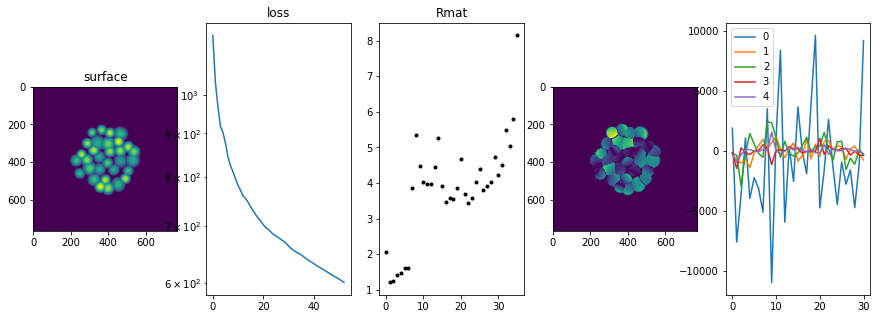

In [ ]:
# Options:
step_size = 1e-4   #1e-8 works well for l2
use_averaged_gradient = False  # True: uses averaged gradient, False: uses single gradient 
optimizer_type = 'gd'           # options: 'gd': normal gradient descent, 'nesterov': nesterov acceleration
num_iterations = 200
num_batches = 1
randomize_z = False   #If true, randomize zlist each epoch. If false, leave original order.

#optimizer=tf.train.GradientDescentOptimizer(learning_rate=step_size)
optimizer = tf.train.AdamOptimizer(learning_rate=step_size)
#optimizer=tf.train.MomentumOptimizer(learning_rate=step_size,momentum= 0.9, use_nesterov = True)
fig=plt.figure(figsize=(15,5))
losslist=[]
rmean=[]

defocus_grid=  1./(np.linspace(1/model.zmin_virtual, 1./model.zmax_virtual, model.Nz * num_batches)) #mm or dioptres
    

if optimizer_type == 'nesterov':
    tk = tf.constant(1,tf.float32)
    tkp = tf.constant(1,tf.float32)

    #xkp = model.variables
    nvars = np.shape(model.variables)[0]
    xk = []
    xkp = []
    [xk.append(tf.Variable(tf.zeros(model.Nlenslets))) for n in range(nvars)]
    [xkp.append(tf.Variable(tf.zeros(model.Nlenslets))) for n in range(nvars)]
    [tf.assign(xkp[n],model.variables[n]) for n in range(nvars)]

    
for i in range(num_iterations):
    if randomize_z:
        defocus_epoch = np.random.permutation(defocus_grid)
    else:
        defocus_epoch = defocus_grid
    for j in range(0, num_batches):
        if use_averaged_gradient == True:
            grad,lossvalue, Rmat =  averaged_gradient(model, loss, num_averages = 10)
        else: 
            grad, lossvalue, Rmat = gradients_and_scaling(model, loss, defocus_epoch[j*model.Nz:j*model.Nz+model.Nz])  # initial value 


        #grad,lossvalue, Rmat=gradient(model,loss)

       # new_xpos = model.xpos - step_size*grad[2]
       # new_ypos = model.xpos - step_size*grad[3] 
        #new_grad, test_dist, test_dist_bool = constrain_distances(model, new_xpos, new_ypos, grad) # apply constraint 


        # Gradient step
        if optimizer_type == 'gd':
            optimizer.apply_gradients(zip(grad,model.variables),global_step=tf.train.get_or_create_global_step())
            # Projection step
            project_to_aper_keras(model)

        if optimizer_type == 'nesterov':

            optimizer.apply_gradients(zip(grad,model.variables),global_step=tf.train.get_or_create_global_step())


            # Projection step
            project_to_aper_keras(model)

            # Update variables for next loop
            tk = tkp
            [tf.assign(xk[n],xkp[n]) for n in range(nvars)]

            # Get state after project (gradient_step(yk))
            [tf.assign(xkp[n],model.variables[n]) for n in range(nvars)]

            #Acceleration
            tkp = 0.5*(1.0 + tf.sqrt(1.0 + 4*tf.square(tk)))

            bkp = (tk - 1)/tkp
            ykp = [xkp[n] + bkp*(xkp[n] - xk[n]) for n in range(nvars)]


            # Update model variables (yk)
            [model.variables[n].assign(ykp[n]) for n in range(nvars)]




        T,aper,T2=make_lenslet_tf_zern(model)

        losslist.append(lossvalue)

        # Plotting Everything 
        plt.subplot(1,5,1)
        plt.cla()
        plt.imshow(T.numpy())
        plt.title('surface')

        plt.subplot(1,5,2)
        plt.cla()
        plt.semilogy(losslist)
        plt.title('loss')

        plt.subplot(1,5,3)
        plt.cla()
        pl = plt.plot(Rmat.numpy(),'k.')
        plt.title('Rmat')

        plt.subplot(1,5,4)
        plt.cla()
        plt.imshow(np.abs(T-T2)); #plt.colorbar()
        
        #pl = plt.plot(model.rlist.numpy(),'k.')
        #plt.title('radii')
        
        plt.subplot(1,5,5)
        plt.cla()
        plt.plot(grad[-1][:,0].numpy())
        plt.plot(grad[-1][:,1].numpy())
        plt.plot(grad[-1][:,2].numpy())
        plt.plot(grad[-1][:,3].numpy())
        plt.plot(grad[-1][:,4].numpy())
        plt.legend(('0', '1', '2', '3', '4'))


        display.display(plt.gcf())
        display.clear_output(wait=True)
        pl.clear()
        display.display(plt.gcf())
        display.clear_output(wait=True)
#     pl.remove?
    


#cbar = fig.colorbar(rshow)

In [ ]:
# Options:
step_size = 1e-6   #1e-8 works well for l2
use_averaged_gradient = False  # True: uses averaged gradient, False: uses single gradient 
optimizer_type = 'gd'           # options: 'gd': normal gradient descent, 'nesterov': nesterov acceleration
num_iterations = 200
num_batches = 1
randomize_z = False   #If true, randomize zlist each epoch. If false, leave original order.

optimizer=tf.train.GradientDescentOptimizer(learning_rate=step_size)
#optimizer=tf.train.MomentumOptimizer(learning_rate=step_size,momentum= 0.9, use_nesterov = True)
fig=plt.figure(figsize=(15,5))
losslist=[]
rmean=[]

defocus_grid=  1./(np.linspace(1/model.zmin_virtual, 1./model.zmax_virtual, model.Nz * num_batches)) #mm or dioptres
    

if optimizer_type == 'nesterov':
    tk = tf.constant(1,tf.float32)
    tkp = tf.constant(1,tf.float32)

    #xkp = model.variables
    nvars = np.shape(model.variables)[0]
    xk = []
    xkp = []
    [xk.append(tf.Variable(tf.zeros(model.Nlenslets))) for n in range(nvars)]
    [xkp.append(tf.Variable(tf.zeros(model.Nlenslets))) for n in range(nvars)]
    [tf.assign(xkp[n],model.variables[n]) for n in range(nvars)]

    
for i in range(num_iterations):
    if randomize_z:
        defocus_epoch = np.random.permutation(defocus_grid)
    else:
        defocus_epoch = defocus_grid
    for j in range(0, num_batches):
        if use_averaged_gradient == True:
            grad,lossvalue, Rmat =  averaged_gradient(model_noaber, loss, num_averages = 10)
        else: 
            grad, lossvalue, Rmat = gradients_and_scaling(model_noaber, loss, defocus_epoch[j*model.Nz:j*model.Nz+model.Nz])  # initial value 


        #grad,lossvalue, Rmat=gradient(model,loss)

       # new_xpos = model.xpos - step_size*grad[2]
       # new_ypos = model.xpos - step_size*grad[3] 
        #new_grad, test_dist, test_dist_bool = constrain_distances(model, new_xpos, new_ypos, grad) # apply constraint 


        # Gradient step
        if optimizer_type == 'gd':
            optimizer.apply_gradients(zip(grad,model_noaber.variables),global_step=tf.train.get_or_create_global_step())
            # Projection step
            project_to_aper_keras(model_noaber)

        if optimizer_type == 'nesterov':

            optimizer.apply_gradients(zip(grad,model.variables),global_step=tf.train.get_or_create_global_step())


            # Projection step
            project_to_aper_keras(model)

            # Update variables for next loop
            tk = tkp
            [tf.assign(xk[n],xkp[n]) for n in range(nvars)]

            # Get state after project (gradient_step(yk))
            [tf.assign(xkp[n],model_noaber.variables[n]) for n in range(nvars)]

            #Acceleration
            tkp = 0.5*(1.0 + tf.sqrt(1.0 + 4*tf.square(tk)))

            bkp = (tk - 1)/tkp
            ykp = [xkp[n] + bkp*(xkp[n] - xk[n]) for n in range(nvars)]


            # Update model variables (yk)
            [model_noaber.variables[n].assign(ykp[n]) for n in range(nvars)]




        T,aper,T2=make_lenslet_tf_zern(model_noaber)

        losslist.append(lossvalue)

        # Plotting Everything 
        plt.subplot(1,4,1)
        plt.cla()
        plt.imshow(T.numpy())
        plt.title('surface')

        plt.subplot(1,4,2)
        plt.cla()
        plt.semilogy(losslist)
        plt.title('loss')

        plt.subplot(1,4,3)
        plt.cla()
        pl = plt.plot(Rmat.numpy(),'k.')
        plt.title('Rmat')

        plt.subplot(1,4,4)
        plt.cla()
        #plt.imshow(np.abs(T-T2)); #plt.colorbar()
        
        #pl = plt.plot(model.rlist.numpy(),'k.')
        #plt.title('radii')


        display.display(plt.gcf())
        display.clear_output(wait=True)
        pl.clear()
        display.display(plt.gcf())
        display.clear_output(wait=True)
#     pl.remove?
    


#cbar = fig.colorbar(rshow)

In [ ]:
Tnone,_,_= make_lenslet_tf_zern(model_noaber)
Tsome,_,_ =make_lenslet_tf_zern(model)

plt.imshow(Tnone-Tsome)

In [ ]:
Rnone = model_noaber(0)
Rsome = model(0)

plt.plot(Rnone.numpy()), 'x'; plt.plot(Rsome.numpy(), 'o'); plt.legend(('no aberrations', 'aberrations'));

In [ ]:
T1,aper,T2=make_lenslet_tf_zern(model)
plt.figure(figsize = (15,5))
plt.subplot(1,3,1), plt.imshow(T2); plt.colorbar(); plt.title('no aberrations')
plt.subplot(1,3,2), plt.imshow(T1); plt.colorbar(); plt.title('with aberrations')
plt.subplot(1,3,3), plt.imshow(np.abs(T1-T2)); plt.colorbar(); plt.title('difference')

In [ ]:
# Compare spectra
def radial_profile(data, center):
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile

def plot_spectra(model):
    T,aper=make_lenslet_tf(model)
    #model = Model()
    psf_stack = model.gen_psf_stack(T, aper, 0.5)
    stack_spectrum = model.gen_stack_spectrum(psf_stack)
    f, ax = plt.subplots(1,model.Nz,figsize=(25,3))
    for n in range(len(ax)):
        ax[n].plot((model.dc_mask*tf.abs(stack_spectrum[n])).numpy()[0,:model.samples[1]],'r',label='spectrum z{}'.format(n))
        ax[n].plot(model.target_F.numpy()[0,:model.samples[1]],'k',label='Target res: {}'.format(model.target_res))
        ax[n].legend()
        ax[n].set_title('Spectrum')
        ax[n].set_ylim(top=5)
        
def compare_spectra(model_init, model_opt):
    T,aper=make_lenslet_tf(model_init)
    #model = Model()
    psf_stack = model_init.gen_psf_stack(T, aper, 0.5)
    stack_spectrum_init = model_init.gen_stack_spectrum(psf_stack)
    
    T,aper=make_lenslet_tf(model_opt)
    #model = Model()
    psf_stack = model_opt.gen_psf_stack(T, aper, 0.5)
    stack_spectrum_opt = model_opt.gen_stack_spectrum(psf_stack)
    
    f, ax = plt.subplots(1,model.Nz,figsize=(25,3))
    for n in range(len(ax)):
        ax[n].plot((model_init.dc_mask*tf.abs(stack_spectrum_init[n])).numpy()[0,:model.samples[1]],'r',label='Initial spectrum z{}'.format(n))
        ax[n].plot((model_opt.dc_mask*tf.abs(stack_spectrum_opt[n])).numpy()[0,:model.samples[1]],'k',label='Optimized spectrum z{}'.format(n))
        ax[n].legend()
        ax[n].set_title('Spectrum')
        ax[n].set_ylim(top=5)
        
def plot_spectra_radial(model):
    T,aper=make_lenslet_tf(model)
    #model = Model()
    psf_stack = model.gen_psf_stack(T, aper, 0.5)
    stack_spectrum = model.gen_stack_spectrum(psf_stack)
    f, ax = plt.subplots(1,model.Nz,figsize=(25,3))
    for n in range(len(ax)):
        radprof = radial_profile((model.dc_mask*tf.abs(stack_spectrum[n])).numpy(),(0,0))
        ax[n].plot(radprof[:model.samples[1]],'r',label='spectrum z{}'.format(n))
        ax[n].plot(model.target_F.numpy()[0,:model.samples[1]],'k',label='Target res: {}'.format(model.target_res))
        ax[n].legend()
        ax[n].set_title('Spectrum')
        ax[n].set_ylim(top=5)

        
# radial average
def compare_spectra_radial(model_init, model_opt):
    T,aper=make_lenslet_tf(model_init)
    #model = Model()
    psf_stack = model_init.gen_psf_stack(T, aper, 0.5)
    stack_spectrum_init = model_init.gen_stack_spectrum(psf_stack)
    
    T,aper=make_lenslet_tf(model_opt)
    #model = Model()
    psf_stack = model_opt.gen_psf_stack(T, aper, 0.5)
    stack_spectrum_opt = model_opt.gen_stack_spectrum(psf_stack)
    
    f, ax = plt.subplots(1,model.Nz,figsize=(25,3))
    for n in range(len(ax)):
        
        radprof_init = radial_profile((model_init.dc_mask*tf.abs(stack_spectrum_init[n])).numpy(),(0,0))
        ax[n].plot(radprof_init[:model_init.samples[1]],'r',label='Init z{}'.format(n))
        #ax[n].plot((model_init.dc_mask*tf.abs(stack_spectrum_init[n])).numpy()[0,:model.samples[1]],'r',label='Initial spectrum z{}'.format(n))
        #ax[n].plot((model_opt.dc_mask*tf.abs(stack_spectrum_opt[n])).numpy()[0,:model.samples[1]],'k',label='Optimized spectrum z{}'.format(n))
        radprof_opt = radial_profile((model_opt.dc_mask*tf.abs(stack_spectrum_opt[n])).numpy(),(0,0))
        ax[n].plot(radprof_opt[:model_init.samples[1]],'k',label='Opt z{}'.format(n))
        ax[n].legend()
        ax[n].set_title('Radially averaged spectrum')
        ax[n].set_ylim(top=5)
    
#model_opt = Model()
#model_opt.load_weights('C:\\Users\\herbtipa\\logsumexp_1000_2p5.hd5')
plot_spectra_radial(model_init)


#re_init_model()
plot_spectra_radial(model)
compare_spectra_radial(model_init, model)

In [ ]:
Ropt = model(0).numpy()
xcorr_opt = calc_max_xcorr(model)
Rinit = model_noaber(0).numpy()
xcorr_init = calc_max_xcorr(model_noaber)

f, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(Ropt[:model.Nz], 'rx',label='aberrations')
ax[0].plot(Rinit[:model.Nz],  'k.',label='no aberrations')
ax[0].legend()
ax[0].set_title('Spectral fitting')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('z-plane')


ax[1].plot(xcorr_opt, 'rx',label='aberrations')
ax[1].plot(xcorr_init,  'k.',label='no aberrations')
ax[1].legend()
ax[1].set_title('Cross correlations')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('z-plane')

In [ ]:
Ropt = model(0).numpy()
xcorr_opt = calc_max_xcorr(model)
Rinit = model_init(0).numpy()
xcorr_init = calc_max_xcorr(model_init)

f, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(Ropt[:model.Nz], 'rx',label='optimized')
ax[0].plot(Rinit[:model.Nz],  'k.',label='init')
ax[0].legend()
ax[0].set_title('Spectral fitting')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('z-plane')


ax[1].plot(xcorr_opt, 'rx',label='optimized')
ax[1].plot(xcorr_init,  'k.',label='init')
ax[1].legend()
ax[1].set_title('Cross correlations')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('z-plane')

In [ ]:
def plot_psf_stack(model):
    T,aper, T2=make_lenslet_tf_zern(model)
    test2 = model.gen_psf_stack(T, aper, .5, zplanes = 1./(np.linspace(1/model.zmin_virtual, 1./model.zmax_virtual, 20)))
    test22 = model.gen_psf_stack(T2, aper, .5, zplanes = 1./(np.linspace(1/model.zmin_virtual, 1./model.zmax_virtual, 20)))
    
    #test = model.gen_stack_spectrum(test2)
    #test3=model.gen_correlation_stack(test)
    #ax[0].imshow(T)
    #plt.plot((model.dc_mask * tf.abs(test[1]))[-1,:200].numpy())
    #plt.plot((model.dc_mask * model.target_F)[-1,:200].numpy())
    for z in range(len(test2)):
        fig = plt.figure(figsize=(15,5))
        plt.cla()
        plt.subplot(1,2,1), plt.imshow(test2[z].numpy())
        plt.subplot(1,2,2), plt.imshow(test22[z].numpy())
        #plt.plot(np.abs(test3[z][model.samples[0],:]))

        display.display(fig)
        display.clear_output(wait=True)
        plt.pause(.5)


In [ ]:
#z_list = 1./(np.linspace(1/model.zmin_virtual, 1./model.zmax_virtual, 20)) #mm or dioptres
plot_psf_stack(model)

In [ ]:
model.zernlist

In [ ]:
def psf_slider(z, psf_stack):
    
    #test = model.gen_stack_spectrum(test2)
    fig = plt.figure(figsize=(15,10))
    plt.imshow(psf_stack[z].numpy())
    plt.show()
    return fig

    

In [ ]:
z_list = 1./(np.linspace(1/model.zmin_virtual, 1./model.zmax_virtual, 15)) #mm or dioptres


In [ ]:
T,aper=make_lenslet_tf(model)
test2 = model.gen_psf_stack(T, aper, .5, zplanes_opt = z_list)
np.shape(test2[0].numpy())

In [ ]:
from ipywidgets import interact, widgets
fig = plt.figure(figsize=(15,10))
interact(psf_slider, z = widgets.IntSlider(min=1, max = 15, step=1, value=1), test2)

In [ ]:
plot_psf_stack(model)

## Function to run reconstructions in loop (to run many initializations)

In [ ]:
def run_opt(iterations, model, ind, CA):
    
    xpos0 = model.xpos.numpy()
    ypos0 = model.ypos.numpy()
    rlist0 = model.rlist.numpy()
    offset0 = model.lenslet_offset.numpy()
    
    step_size = 1e-8
    optimizer=tf.train.GradientDescentOptimizer(learning_rate=step_size)

    losslist=[]
    for i in range(iterations):
        
        num_grads = 10
        grad_averaged = 1/num_grads * gradients_and_scaling(model, loss)
        for g in range(0,num_grads-1):
            grads, lossvalue = gradients_and_scaling(model, loss)
        
            for grad_ind in range(0,len(model.variables)):
                grad_averaged[grad_ind] = grad_averaged[grad_ind] + 1/num_grads * grads[grad_ind]

        
        optimizer.apply_gradients(zip(grads_averaged,model.variables),global_step=tf.train.get_or_create_global_step())
        project_to_aper_keras(model)
        T,aper=make_lenslet_tf(model)

        losslist.append(lossvalue.numpy())
        
    xposf = model.xpos.numpy()
    yposf = model.ypos.numpy()
    rlistf = model.rlist.numpy()
    offsetf = model.lenslet_offset.numpy()    
    save_dict = {'xpos0': xpos0,
             'ypos0': ypos0,
             'rlist0': rlist0,
             'offset0': offset0,
            'losses': losslist,
             'xposf': xposf,
             'yposf': yposf,
             'rlistf': rlistf,
             'offsetf': offsetf,}
    
    save_extension = 'test_'+ str(CA)+ '_' + str(ind)+'_initial_loss_' + str(losslist[0])+ '_final_loss_' + str(losslist[-1]) + '.mat'
    scipy.io.savemat('/home/kyrollos/randoscope/data_1_12_2019/' + save_extension, save_dict)
    

In [ ]:
# Re-initialize model
model.xpos.assign(xinit)
model.ypos.assign(yinit)
model.lenslet_offset.assign(offsetinit)
model.rlist.assign(rinit)
print(model.xpos)

In [ ]:
#[model.variables[n].assign(init_vars) for n in range(nvars)]
# Gradient descent
step_size = 1e-9
optimizer=tf.train.GradientDescentOptimizer(learning_rate=step_size)
fig=plt.figure(figsize=(15,5))
losslist=[]
rmean=[]
tk = tf.constant(1,tf.float32)
tkp = tf.constant(1,tf.float32)
# xk = model.variables
# xkp = model.variables
# nvars = np.shape(xk)[0]
for i in range(70):
    grad,lossvalue, Rmat=gradient(model,loss_sum)

   # new_xpos = model.xpos - step_size*grad[2]
   # new_ypos = model.xpos - step_size*grad[3] 

    #new_grad, test_dist, test_dist_bool = constrain_distances(model, new_xpos, new_ypos, grad) # apply constraint 
    #print(new_grad)
    grad[1] = grad[1] * 100000  #Radius
    grad[2]=grad[2]*10000 # X
    grad[3]=grad[3]*10000 # Y
    #grad[2] = grad[2]*new_grad[0,:]*10000
   # grad[3] = grad[3]*new_grad[1,:]*10000   # update the gradient
#    grad[1] = grad[1]*
    
    #grads=remove_nan_gradients(grad)
    #print(grads)
    
    # Gradient step
    optimizer.apply_gradients(zip(grad,model.variables),global_step=tf.train.get_or_create_global_step())
    
    # Projection step
    project_to_aper_keras(model)
    

    
    T,aper=make_lenslet_tf(model)

    losslist.append(lossvalue)
    plt.subplot(1,3,1)
    plt.cla()
    #plt.plot(model.xpos.numpy(),model.ypos.numpy(),'o')
    #plt.axis('equal')
    #rmean.append(tf.reduce_mean(model.rlist.numpy()))
    #plt.plot(rmean)
    plt.imshow(T.numpy())
    plt.subplot(1,3,2)
    plt.cla()
    plt.semilogy(losslist)
    
    
    plt.subplot(1,3,3)
    plt.cla()

    #rshow = plt.imshow(np.tril(Rmat[model.Nz+1:-1])
#     cbar = fig.colorbar(rshow)    
    pl = plt.plot(Rmat.numpy(),'k.')
    
    display.display(plt.gcf())
    display.clear_output(wait=True)
    pl.clear()
#     cbar.remove()
# cbar = fig.colorbar(rshow)

In [ ]:
fig = plt.figure(figsize=(15,3))
T,aper=make_lenslet_tf(model)
test2 = model.gen_psf_stack(T, aper, .5)
test = model.gen_stack_spectrum(test2)
test4=model.gen_correlation_stack(test)
#ax[0].imshow(T)


# for z in range(len(test4)):

#     #ax[1].imshow(tf_fftshift(tf.abs((test[z] * tf.conj(test[z])))), vmin = 0, vmax = 50)
#     #ax[2].imshow(tf_fftshift(tf.abs((test[z] * tf.conj(test[z]))) - model.target_F), vmin = -50, vmax = 50)
#     plt.cla()
#     #ax[1].imshow((tf.real((test[z] * tf.conj(test[z])))), vmax = 50)
#     plt.subplot(1,2,1)
#     plt.plot(np.abs(test3[z][model.samples[0],:]))
    
#     plt.subplot(1,2,2)
#     plt.plot(np.abs(test4[z][model.samples[0],:]))

#     display.display(fig)
#     display.clear_output(wait=True)
#     plt.pause(.5)

In [ ]:
plt.figure(figsize=(20,15))
for z in range(7):

    #ax[1].imshow(tf_fftshift(tf.abs((test[z] * tf.conj(test[z])))), vmin = 0, vmax = 50)
    #ax[2].imshow(tf_fftshift(tf.abs((test[z] * tf.conj(test[z]))) - model.target_F), vmin = -50, vmax = 50)
    #plt.cla()
    #ax[1].imshow((tf.real((test[z] * tf.conj(test[z])))), vmax = 50)
    plt.subplot(7,2,z*2+1)
    ind = (model.Nz+1) * (z)
    plt.plot(np.abs(test3[ind][model.samples[0],:]))
    
    plt.subplot(7,2,z*2+2)
    plt.plot(np.abs(test4[ind][model.samples[0],:]))

    #display.display(fig)
    #display.clear_output(wait=True)
    #plt.pause(.5)

In [ ]:
plt.imshow(tf.reshape(model(0),(model.Nz, model.Nz)))
plt.colorbar()

In [ ]:
plt.plot(np.sort(1/model.rlist.numpy()),'o')

In [ ]:
model.lenslet_offset

In [ ]:
T,aper=make_lenslet_tf(model)
test2 = model.gen_psf_stack(T, aper, 0.5)
test = model.gen_stack_spectrum(test2)
fig = plt.figure()

f,ax = plt.subplots(1,2,figsize=(20,20))

ax[0].imshow(T)


for z in range(model.Nz):
    #ax[1].imshow((tf.real((test[z] * tf.conj(test[z])))) - model.target_F, vmax = 50)
    im_disp = ax[1].imshow((tf.real((test2[z]))),vmax = .3)
    cbar = plt.colorbar(im_disp, ax=ax[1])
    display.display(f)
    display.clear_output(wait=True)
    cbar.remove()
    #plt.pause(1)

In [ ]:
def animate_zstack(i):
#    ax[1].clear()
    ax[1].imshow(tf.real(test2[i]),vmax = .1)

In [ ]:
#model.save_weights('C:\\Users\\herbtipa\\lenslets_one_per_depth.hd5',overwrite=False)

In [ ]:
f,ax = plt.subplots(1,2,figsize=(20,20))
ax[0].imshow(T)
ani = animation.FuncAnimation(f, animate_zstack, frames = range(model.Nz), interval = 500, repeat = False)
# plt.show(ani)
#Writer = animation.writers['ffmpeg']

# HTML(ani.to_html5_video())
for i in range(model.Nz):
    animate_zstack(i)
    display.display(f)
    display.clear_output(wait=True)
    f.savefig('C:\\Users\\herbtipa\\foo_{}.png'.format(i))
    



In [ ]:
#jacobian=[]
#for i in range (model.Nz**2):
#    with tf.GradientTape() as tape:
#        #tape.watch(model.variables)
#        R=model(0)
#        jacobian.append(tape.gradient(R[i], model.variables))
